# Training Engineering and Model Assessments on the AI-ready PHIPS Image Classification Dataset

##### This notebook performs a thorough analysis of training strategies and model assessment of the Random Forest Classifier model for classifying features in the "PHIPS_CrystalHabitAI_Dataset.nc" dataset. Random Forest Classifier was determined to be the best-performing model in the `autoML_hyperparamter_tuning.iypnb` notebook

## Understanding Cross-Validation and Train-Validation-Test Splits

##### **Cross-Validation (CV):** A technique that divides the training data into multiple folds, repeatedly trains and tests the model on these folds, and then averages the results to give a robust estimate of model performance.

* k-Fold Cross-Validation: The most common form, where the data is divided into `k` folds. The model is trained on `k-1` folds and tested on the remaining fold, rotating through each fold as a test set once.

##### **Train-Validation-Test Split:** This approach separates the dataset into three parts:
* Training Set: Used to fit/train the model.
* Validation Set: Used to tune hyperparameters or evaluate models during training to avoid overfitting.
* Test Set: A final hold-out set used solely for evaluating the model's performance after training is complete. This data is not seen by the model during training or tuning.

## 1. Data pre-processing 

In [4]:
# Import basic packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define the file path of the dataset
file_path = '/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

In [ ]:
# Flatten the image arrays (convert each image from a 2D array to a 1D vector)
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Scales features in data using statistics that are robust to outliers.
# Before applying PCA (a dimensionality reduction method), it's important to scale the data so that each feature contributes equally to the analysis.

from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(image_arrays)

from sklearn.decomposition import PCA

# Apply PCA with the optimal number of components (63 in this case, obtained from the 'autoML_hyperparameter_tuning.ipynb' notebook)
pca = PCA(n_components=63)
pca_result = pca.fit_transform(scaled_data)

# Convert the PCA results into a DataFrame
pca_columns = [f'PC{i+1}' for i in range(63)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
pca_df['habit_type'] = ds['label'].values  # Adding the target label

## 2. Implementing Cross-Validation and Train-Val-Test Splits

##### Start with a Train-Validation-Test Split

Split the full dataset into 80% training + validation and 20% test. This way, the test set remains unseen until final evaluation.
Within the 80% training set, split again into 75% for training and 25% for validation. This provides a validation set for tuning without using the test data.

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Train-Test Split (80/20)
X = pca_df.drop(columns='habit_type')  # Features
y = pca_df['habit_type']               # Target labels

# Split 80% for training+validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train-Validation Split (within the 80%)
# Split again to get 75% training and 25% validation of the training set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

##### Perform Cross-Validation on the Training Set

Apply a 5-fold cross-validation on the training set, using the `cross_val_score` function, which gives an average accuracy across 5 folds. This provides a robust measure of model performance across different subsets of data. After cross-validation, train the model on the full training set and validate it on the validation set. This step helps refine the model and ensures it generalizes well without relying on the test set.

In [12]:
# Step 3: Perform Cross-Validation on the Training Set (e.g., 5-fold CV)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=230, max_depth=7, criterion='entropy', random_state=42)

In [13]:
# Perform 5-fold CV on the training set
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy Scores: [0.41509434 0.26415094 0.22641509 0.28301887 0.38461538]
Mean CV Accuracy: 0.3146589259796807


#####  Model Training and Validation

After cross-validation, train the model on the full training set and validate it on the validation set. This step helps refine the model and ensures it generalizes well without relying on the test set.

In [14]:
# Step 4: Train the Model on Full Training Data and Validate
# Train on the full training set and evaluate on the validation set
model.fit(X_train, y_train)
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions, average='weighted')
print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)

Validation Accuracy: 0.38636363636363635
Validation F1 Score: 0.39642894711292215


##### Final Test Evaluation

After tuning and finalizing the model, train on the combined training + validation data and evaluate on the hold-out test set. This gives an unbiased performance measure of the model.

In [15]:
# Step 5: Final Evaluation on the Test Set
# After tuning, train on combined training+validation set for final test evaluation
model.fit(X_train_val, y_train_val)
test_predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)

Test Accuracy: 0.38636363636363635
Test F1 Score: 0.3800812609732888


##### A test accuracy of ~38.6% and test F1 score of ~38.0% suggests moderate performance of the Random Forest Classifer model. It correctly classified only about 38.6% of test samples. Given the multi-class nature of the problem, this may indicate the model is struggling to differentiate between classes effectively. The F1 Score, which balances precision and recall, is close to the accuracy score, which implies that precision and recall are similar. This balance is helpful in multi-class problems, where it’s crucial to handle both false positives and false negatives effectively.

## 3. Implementing Stratified Cross-Validation

##### The current approach (cross-validation and a single train-validation-test split) provides a general measure of performance but may not fully capture *generality* if the data includes diverse subsets with varying characteristics (e.g., different ice crystal types, lighting conditions, or image scales). To ensure robust generalization across all data variations, stratified cross-validation will be implemented, which is a technique that may better demonstrate model performance on diverse subsets.

##### **On Stratified Cross-Validation:**
* What It Does: Ensures that each fold in cross-validation has a similar distribution of classes, maintaining class diversity across all training and validation sets.
* Why It Helps: This reduces the risk of over- or under-representing any specific class in a single fold and provides a better generalization measure across all types of ice crystals.

In [20]:
# Implementing Stratified K-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print("Stratified K-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Stratified K-Fold Cross-Validation Accuracy Scores: [0.30188679 0.30188679 0.37735849 0.22641509 0.42307692]
Mean Accuracy: 0.32612481857764875
Standard Deviation: 0.06803174647284903


##### A mean accuracy of 32.6% suggests that the current model configuration and features are not effectively capturing class distinctions in the dataset. The standard deviation shows that the model’s performance fluctuates across different data folds, possibly due to class overlap or difficulty in distinguishing between some classes.

## Understanding Bootstrapping and Bagging
##### **Bootstrapping:** A resampling method where we repeatedly sample with replacement from the original dataset to create multiple “bootstrap samples.” Each sample may have some data points repeated and others left out.
##### **Bagging:** Stands for Bootstrap Aggregating. It involves training a model on each bootstrap sample and then averaging or voting on the predictions across models to improve performance and reduce variance. Random Forest, for instance, is a classic example of bagging applied to decision trees.

## 4. Applying Bootstrapping and Bagging to Different Models
##### For this demonstration, the following models will be used: Decision Trees, K-Nearest Neighbors (KNN), Ridge Classifier, and Random Forest. Bootstrapping and bagging will be manually applied to these models

In [ ]:
# Step 1: Set up a function to perform bootstrapping and bagging

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def bagging_model(X_train, y_train, X_test, y_test, model, n_estimators=10):
    """
    Function to perform bagging with specified model and number of bootstrap samples.
    """
    predictions = []

    for _ in range(n_estimators):
        # Create a bootstrap sample from the training data
        X_bootstrap, y_bootstrap = resample(X_train, y_train, random_state=np.random.randint(0, 10000))
        
        # Fit the model on the bootstrap sample
        model.fit(X_bootstrap, y_bootstrap)
        
        # Predict on the test data and store predictions
        predictions.append(model.predict(X_test))
    
    # Aggregate predictions by majority vote (for classification)
    final_predictions = np.array(predictions).T
    majority_vote = [np.bincount(row).argmax() for row in final_predictions]
    
    # Calculate and return accuracy
    accuracy = accuracy_score(y_test, majority_vote)
    return accuracy

In [34]:
# Step 2: Set up different model architectures and evaluate bagging performance

from sklearn.model_selection import train_test_split

# Split the data
X = pca_df.drop(columns='habit_type')  # Features
y = pca_df['habit_type']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform y_test using the same encoder
y_test_encoded = label_encoder.transform(y_test)

In [46]:
# Perform bagging on each model and print accuracy
# Use the encoded y values in all model evaluations
from sklearn.ensemble import BaggingClassifier

# Decision Tree Model with Bagging
bagged_tree = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)
bagged_tree.fit(X_train, y_train_encoded)
tree_accuracy = bagged_tree.score(X_test, y_test_encoded)
print("Bagged Decision Tree Accuracy:", tree_accuracy)


Bagged Decision Tree Accuracy: 0.32954545454545453


In [47]:
# Decision Tree Model with Bagging
bagged_tree = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)
bagged_tree.fit(X_train, y_train_encoded)
tree_accuracy = bagged_tree.score(X_test, y_test_encoded)
print("Bagged Decision Tree Accuracy:", tree_accuracy)

Bagged Decision Tree Accuracy: 0.32954545454545453


In [48]:
# KNN Model with Bagging
bagged_knn = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3), n_estimators=10, random_state=42)
bagged_knn.fit(X_train, y_train_encoded)
knn_accuracy = bagged_knn.score(X_test, y_test_encoded)
print("Bagged KNN Accuracy:", knn_accuracy)

Bagged KNN Accuracy: 0.2840909090909091


In [49]:
from sklearn.linear_model import RidgeClassifier

# Ridge Model with Bagging
ridge_model = RidgeClassifier(random_state=42)
bagged_ridge = BaggingClassifier(estimator=ridge_model, n_estimators=10, random_state=42)
bagged_ridge.fit(X_train, y_train_encoded)
ridge_accuracy = bagged_ridge.score(X_test, y_test_encoded)
print("Bagged Ridge Classifier Accuracy:", ridge_accuracy)

Bagged Ridge Classifier Accuracy: 0.32954545454545453


In [50]:
# Set up the BaggingClassifier with RandomForest as the base estimator
model = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
    n_estimators=10,  # Number of bagged estimators (i.e., the number of Random Forest models in the ensemble)
    bootstrap=True,   # Enable bootstrapping for each base estimator
    random_state=42
)

# Fit the BaggingClassifier on the training data
model.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Bagging Random Forest Accuracy:", accuracy)

Bagging Random Forest Accuracy: 0.3409090909090909


##### -- INSERT HERE DISCUSSION COMPARING THE DIFFERENT BAGGED MODEL ACCURACIES, WHAT IT MEANS THAT THEY ARE LOW, ETC.--

## 5. Visualize Model Performance (focusing on the Random Forest model)

##### Plotting Learning Curves Using Cross-Validation
Learning curves show the model's accuracy or loss over training rounds or different data sizes. This helps assess how well the model is learning and whether it’s underfitting or overfitting. 

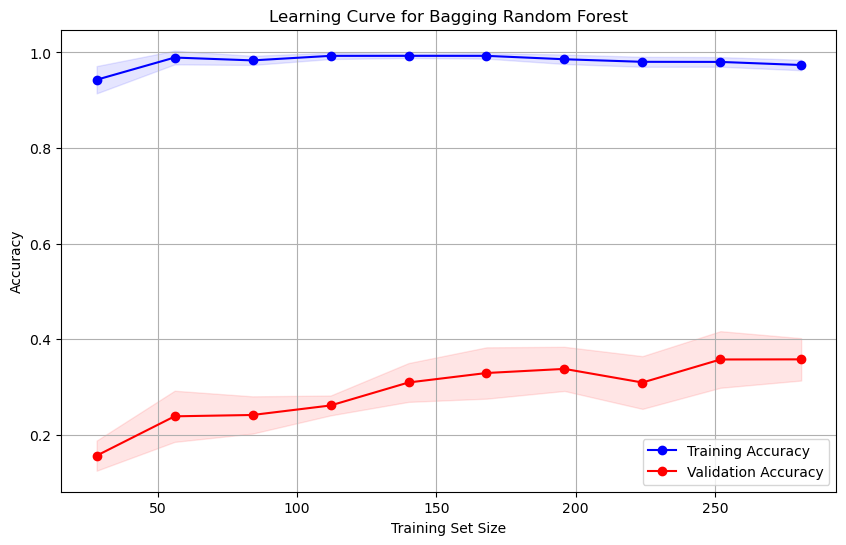

In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train_encoded, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="red", marker='o')

# Fill between with standard deviations
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.1)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Bagging Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Learning Curve

* Training Accuracy: Shows how well the model performs on the training data.
* Validation Accuracy: Shows how well the model generalizes to unseen data.
* Gap Between Curves: A large gap with high training accuracy and low validation accuracy indicates overfitting. A small gap with both high training and validation accuracy suggests good generalization.

-- INSERT DICUSSION OF YOUR INTERPRETATION OF THE LEARNING CURVE FOR RANDOM FOREST --

##### Plotting Accuracy Across Training Rounds
This plot gives a visual understanding of how the model’s performance evolves as more rounds are added to the ensemble, helping identify the optimal ensemble size. 

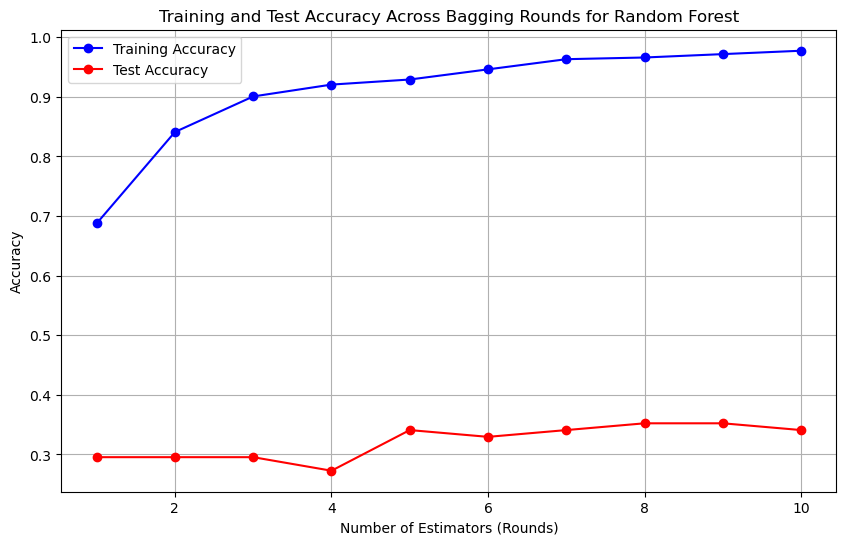

In [52]:
# Initialize lists to store accuracies for each round
train_accuracies = []
test_accuracies = []
n_estimators = 10  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_estimators + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    model = BaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
        n_estimators=i,  # Number of bagged estimators
        bootstrap=True,
        random_state=42
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)
    
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train_encoded, model.predict(X_train))
    test_accuracy = accuracy_score(y_test_encoded, model.predict(X_test))
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot Training and Test Accuracy Across Training Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy", marker='o', color="blue")
plt.plot(range(1, n_estimators + 1), test_accuracies, label="Test Accuracy", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Plot
* Increasing Accuracy with More Estimators: If both lines increase as the number of estimators grows, the model benefits from the additional bagging rounds.
* Plateauing or Dipping Test Accuracy: Indicates the point where adding more estimators does not improve generalization or might start leading to overfitting.

-- INSERT DISCUSSION ON PLOT INTERPRETATION --

##### Visualizing Training and Validation Loss for Logistic Regression
To visualize training and validation loss for the Random Forest model, log-loss (or negative log-likelihood loss) will be used, which provides a measure of how well the predicted probabilities align with the true labels. Although Random Forest is not typically optimized with log-loss, we can still calculate and plot it to understand model calibration over training and validation data.

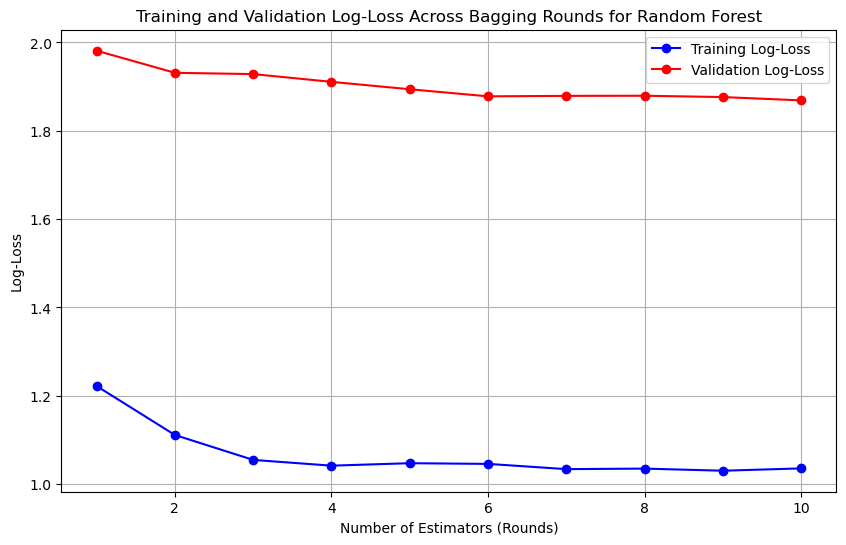

In [53]:
from sklearn.metrics import log_loss

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
n_rounds = 10  # Number of bagging rounds to evaluate

# Loop over each round of bagging, increasing the number of estimators each time
for i in range(1, n_rounds + 1):
    # Define the Bagging Random Forest model with increasing number of estimators
    model = BaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42),
        n_estimators=i,
        bootstrap=True,
        random_state=42
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train_encoded)
    
    # Predict probabilities on training and validation sets
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_test)
    
    # Calculate log-loss for training and validation data
    train_loss = log_loss(y_train_encoded, y_train_pred_proba)
    val_loss = log_loss(y_test_encoded, y_val_pred_proba)
    
    # Store the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot Training and Validation Loss Across Bagging Rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_rounds + 1), train_losses, label="Training Log-Loss", marker='o', color="blue")
plt.plot(range(1, n_rounds + 1), val_losses, label="Validation Log-Loss", marker='o', color="red")
plt.xlabel("Number of Estimators (Rounds)")
plt.ylabel("Log-Loss")
plt.title("Training and Validation Log-Loss Across Bagging Rounds for Random Forest")
plt.legend(loc="best")
plt.grid()
plt.show()

Interpreting the Plot
* Decreasing Log-Loss: Indicates that the model is learning better class probabilities, improving its confidence in predictions.
* Plateauing Log-Loss: Shows that adding more rounds doesn’t improve model calibration and performance further.
* Diverging Curves: If training log-loss keeps decreasing while validation log-loss increases, this suggests overfitting.

-- INSERT DISCUSSION ON PLOT INTERPRETATION --

## 6. Summary

##### INSERT BRIEF SUMMARY ON OVERALL RESULTS, INCLUDING HOW THE METHODS AFFECT MODEL GENERALITY AND PERFORMANCE